# Init

In [1]:
import numpy as np
import pylab as plt

# Bootstrap distribution of means

## Estimation of the mean

Suppose you have a set of random variables $x_i \in X$ from which you would like to compute the mean value $\mu(X)$.

In [2]:
mu0  = np.random.uniform(low=1, high=2)
std0 = mu0 * np.random.uniform(low=0.7, high=0.9)

NX = 100
X  = np.random.normal(mu0, std0, size=100)

For normally distributed variables in the limit of large statistics, this is straight forward.
The mean value and standard deviation are computed by their estimators
\begin{align}
    \hat \mu(X) &= \frac{1}{N_X}\sum\limits_{i=1}^{N_X} x_i \, , &
    \hat \sigma(X) = \sqrt{\frac{1}{N_X-1}\sum\limits_{i=1}^{N_X} (x_i - \mu)^2 } \, .  
\end{align}

In [3]:
meanX = np.mean(X)
sdevX = np.std(X, ddof=1)

print("muEst = {mu} +/- {std}".format(mu=meanX, std=sdevX))

muEst = 1.9876414742755415 +/- 1.6170022713736447


For 100 samples one could acutally expect to have a quite nice result for the mean:

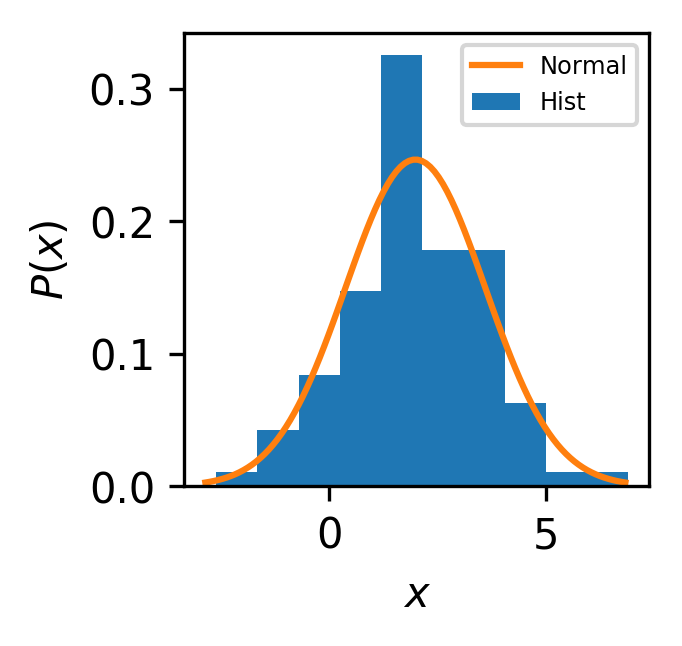

In [4]:
fig, ax = plt.subplots(dpi=300, figsize=(2,2))

xRange = np.linspace(meanX-3*sdevX, meanX+3*sdevX, 100)
normal = np.exp( - (xRange-meanX)**2 / 2 / sdevX**2 ) / np.sqrt(2*np.pi) / sdevX

ax.hist(X, normed=True, label="Hist")
ax.plot(xRange, normal, label="Normal")

ax.legend(loc="best", fontsize="xx-small")
ax.set_xlabel("$x$")
ax.set_ylabel("$P(x)$")


plt.show(fig)

We are now interested in the goodness of our estimatation for the mean value. 
The uncertainty of this estimation is defined by the infinite statistics mean value compared to the estimated mean value for finite statistics. However, one usually does not have infinite statistics.
Also, this uncertainty, at least in the test case, will most likely be smaller than the standard deviation.

## Bootstrap

To answser this question, we generate Bootstrapp which mimic the generation of a larger ensemble by drawing from the inital distribution. For a more detailed description I refer to https://arxiv.org/abs/hep-lat/0506036.

1. We generate a new set of indices
    \begin{align}
        i &\in I_{n_B} \, , & 
        I &= \mathrm{Uniform}(1, N_X) \, , & 
        |I_{n_B}| &= N_{Size} \, .
    \end{align}
2. We compute the mean of the new distribution 
    $$\hat\mu(X, I_{n_B}) = \frac{1}{|I_{n_B}|}\sum\limits _{i\in I_{n_B}} x_i\,.$$
3. We repeat this procedure to generate a set of means 
    $$X_\mu = \{ \hat\mu(X, I_{1}),\hat\mu(X, I_{2} ) , \cdots , \hat\mu(X, I_{N_B}) \}\,.$$ 

From this new distribution, one can compute the mean of means and the standard deviation of means to estimate the uncertainty of the mean for the inital data
$$
    \mu(X) = \hat \mu (X_\mu) \pm \hat \sigma(X_\mu) \, .
$$

This procedute is implemented in the `bootstats` package

In [5]:
import bootstats as boot

# Specify the data, must be two-dimensional 
## the first dimension is a random variable
## the last dimension is the random data for each variable
data = np.array([X])
# The number of bootstrap samples (size of X_mu)
NSamples = 1000
# Binning of data (in case one wants to remove auto correlation)
NBinSize = 1
# The size of each bootstrap sample |I_nB|
NSize    = int(data.shape[-1]/NBinSize)

bs = boot.Bootstrapper(data, NSamples=NSamples, NSize=NSize, NBinSize=NBinSize)

meanMean = np.mean(bs.samples)
meanSdev = np.std(bs.samples, ddof=1)

print("mu_0 = {mu0:1.2f}, mu = {meanMean:1.2f} +/- {meanSdev:1.2f}".format(mu0=mu0, meanSdev=meanSdev, meanMean=meanMean))

mu_0 = 1.81, mu = 1.99 +/- 0.16


Note that the mean of the bootstrap means and the standard deviation of the bootstrap means should converege to fixed values when increasing the sample size. In other words, the fluctuation of the mean of bootstrap means and the fluctuation of standard deviation of bootstrap means should be way smaller than the standard deviation of the bootstrap means.

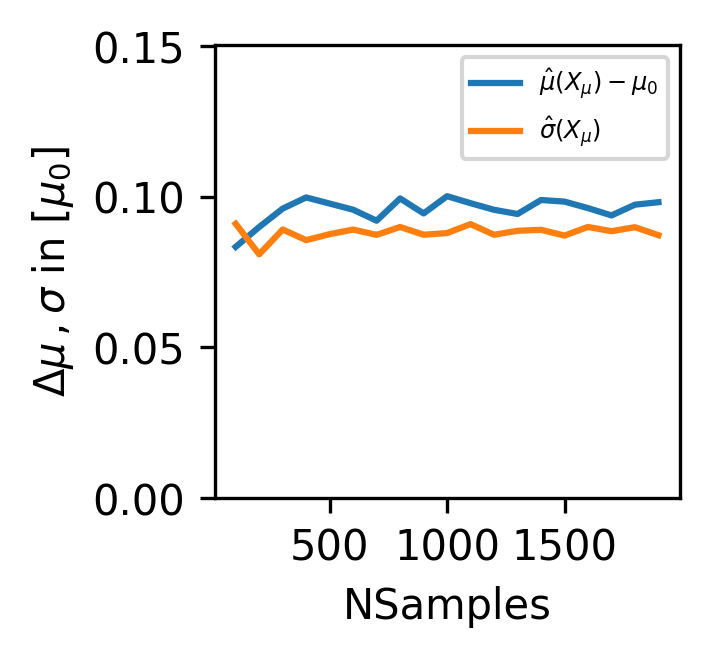

In [6]:
NSamplesRange = range(100, 2000, 100)

meanMeans = []
meanSdevs = []

for NSamples in NSamplesRange:
    bs = boot.Bootstrapper(data, NSamples=NSamples, NSize=NSize, NBinSize=NBinSize)
    
    meanMeans.append( abs(np.mean(bs.samples)-mu0)/mu0 )
    meanSdevs.append( np.std(bs.samples, ddof=1)/mu0 )

fig, ax = plt.subplots(dpi=300, figsize=(2,2))

ax.plot(NSamplesRange, meanMeans, label="$\hat\mu(X_\mu) - \mu_0$")
ax.plot(NSamplesRange, meanSdevs, label="$\hat\sigma(X_\mu)$")

ax.legend(loc="best", fontsize="xx-small")
ax.set_ylabel("$\Delta\mu \, ,  \sigma$ in [$\mu_0$]")
ax.set_xlabel("NSamples")

ax.set_ylim(0, max(meanMeans)*1.5)

plt.show(fig)

## Non-normal distributions

Note that bootstrapping makes no assumptions about the inital distribution

In [7]:
mu0  = np.random.uniform(low=1, high=2)
std0 = mu0 * np.random.uniform(low=0.7, high=0.9)

NX = 100
X  = mu0 + np.random.uniform(low=-std0, high=+std0, size=100)

In [8]:
data = np.array([X])
NSamples = 1000
NBinSize = 1
NSize    = int(data.shape[-1]/NBinSize)

bs = boot.Bootstrapper(data, NSamples=NSamples, NSize=NSize, NBinSize=NBinSize)

meanMean = np.mean(bs.samples)
meanSdev = np.std(bs.samples, ddof=1)

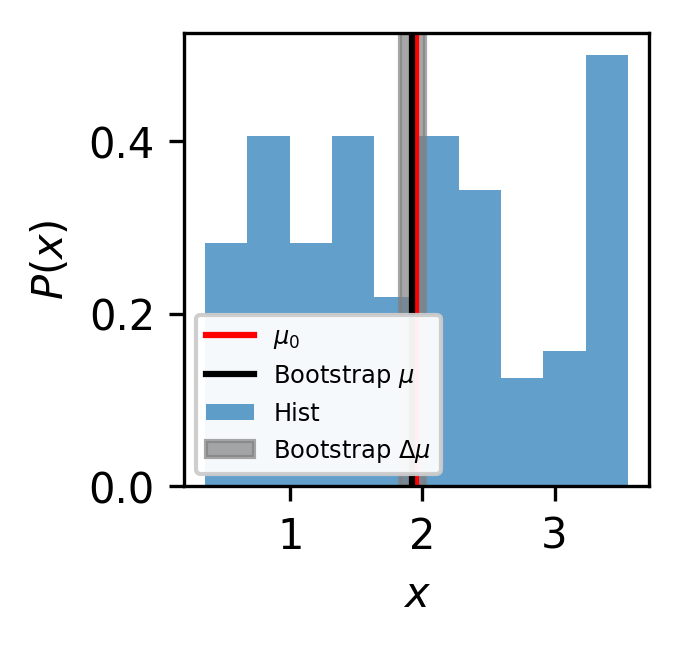

In [9]:
fig, ax = plt.subplots(dpi=300, figsize=(2,2))

ax.hist(X, normed=True, label="Hist", alpha=0.7)
ax.axvline(mu0, label="$\mu_0$", color="red")

ax.axvline(meanMean, label="Bootstrap $\mu$", color="black")
ax.axvspan(meanMean-meanSdev, meanMean+meanSdev, color="gray", label="Bootstrap $\Delta \mu$", alpha=0.7 )


ax.legend(loc="lower left", fontsize="xx-small", frameon=True, framealpha=0.95)
ax.set_xlabel("$x$")
ax.set_ylabel("$P(x)$")


plt.show(fig)